# ORIE 4741 - Exploring Wine

In [1]:
# Here we import everything we need to explore our data.

import pandas as pd
import numpy as np
import scipy.stats as scipy
import scipy.linalg
import matplotlib.pyplot as py
import matplotlib
import random
%matplotlib inline

## Importing our Data

#### Our first approach was to import data using python’s pandas.read_csv

#### Issues

The first issue we ran into occurred when we inspected our raw data in Excel. We noticed that many of the foreign characters such as ‘é’ were not being displayed properly in our imported dataset (see Figure 1.1). This concerned us because the interpretability of the dataset was difficult for potential readers and us; however, after some research on UnicodeDecodeError’s (such as the one given below), we found the problem to be that Excel expected characters to be encoded as UTF-8*. The incorrect outputs were a result of UTF-8 only including ASCII characters; however, our data had a significant amount of non-ASCII characters. 

UnicodeDecodeError: 'utf8' codec can't decode byte 0xa5 in position 0: invalid start byte

*UTF-8 is a character encoding capable of encoding all 1,112,064 valid code points in Unicode using one to four 8-bit bytes.

#### Examples of some issues

See Table in Latex File (Figure 1.1)

#### Initial attempts to fix the encoding issues

We initially tried changing the file type and even starting writing code to replace strange character sequences. This process was labor intensive and took way too long. Then we thought it would make sense to simply remove the data containing any foreign characters and in doing so, learned our dataset was biased towards non-foreign wines and reviews. 

1. Tried changing the excel file’s character encoding.
2. Tried changing the .csv file’s character encoding.
3. Tried using “Apple Numbers” (an excel equivalent) to see if we could encode foreign characters.
4. Tried using Business Intelligence software (Microsoft Power BI) to identify and replace character patterns with an ASCII equivalent (i.e., changing ‘Ã©’ which was supposed to be an ‘é’ to ‘e’). This was time intensive and was not a practical approach.
5. Tried reading the dataset into a .ipynb using Python’s pandas.read_csv; However, one main issue we had was the presence of commas in reviews. This caused our data to transform the fields of those particular examples from the expected 11 fields to over 140. We recognize this transformation as an error in read_csv and our data which added onto our foreign language issues.

#### Understanding our root problem

Our root problem was the character encoding of a .csv file in which our data was stored. 

#### Our solution

We ended up using .json files instead of .csv to store our data. This type of file does not allow us to examine our raw data in Excel, but when importing the file into the .ipynb notebook we found that the method pandas.read_json read-in foreign languages efficiently and accurately without causing the fields to expand or transform. This was mainly a benefit of how .json files structure and store data in defined fields while also including the correct encodings for reading numbers as Float64 rather than strings. 


In [2]:
df = pd.read_json('/Users/alexanderdowney/Downloads/winemag-data_first150k.json')

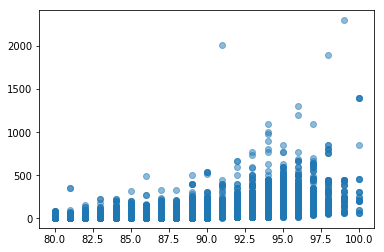

In [3]:
py.scatter(df['points'],df['price'],alpha=0.5)
py.show()
size_of_dataset=[]
size_of_dataset.append(len(df))

In [4]:
df_store=df
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,None,Provence red blend,Domaine de la Bégude
5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,None,Tinta de Toro,Numanthia
6,Spain,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Toro,None,Tinta de Toro,Maurodos
7,Spain,Lush cedary black-fruit aromas are luxe and of...,Carodorum Único Crianza,95,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


### First Step of Cleaning the Dataset 

We noticed that we had some "odd" countries that we didn't expect to see. Also they had a very limited amount of data points and thus would not be helpful in predicting prices for more "common" countries. 

In [5]:
countries = df['country'].unique()
country_count=[]
countries_kept = []
for i in range(0,len(countries)):
    country_count.append(len(df.loc[df['country'] == countries[i]]))
    print(countries[i],len(df.loc[df['country'] == countries[i]]))
for j in range(0,len(countries)):
    if country_count[j]>500:
        countries_kept.append(countries[j])
df = df[df['country'].isin(countries_kept)]
size_of_dataset.append(len(df))

US 62397
Spain 8268
France 21098
Italy 23478
New Zealand 3320
Bulgaria 77
Argentina 5631
Australia 4957
Portugal 5322
Israel 630
South Africa 2258
Greece 884
Chile 5816
Morocco 12
Romania 139
Germany 2452
Canada 196
Moldova 71
Hungary 231
Austria 3057
Croatia 89
Slovenia 94
None 0
India 8
Turkey 52
Macedonia 16
Lebanon 37
Serbia 14
Uruguay 92
Switzerland 4
Albania 2
Bosnia and Herzegovina 4
Brazil 25
Cyprus 31
Lithuania 8
Japan 2
China 3
South Korea 4
Ukraine 5
England 9
Mexico 63
Georgia 43
Montenegro 2
Luxembourg 9
Slovakia 3
Czech Republic 6
Egypt 3
Tunisia 2
US-France 1


### Removing NaN's from our points & price columns

Examining our data some more we realize we have some values in price (our output vector) which are NaN. See index 150922 for an example. We proceed to remove these values.

We selected only the points and price columns as a means for identifying NaNs to remove. Our rationale for only using these columns is some wines have more detailed regions and sub-regions vs others, this is not a data entry error but simply due to industry structure and classification systems. 

In [6]:
df['price']

0         235.0
1         110.0
2          90.0
3          65.0
4          66.0
5          73.0
6          65.0
7         110.0
8          65.0
9          60.0
10         80.0
11         48.0
12         48.0
13         90.0
14        185.0
15         90.0
16        325.0
17         80.0
18        290.0
19         75.0
20         24.0
21         79.0
22        220.0
23         60.0
24         45.0
25         57.0
26         62.0
27        105.0
28         60.0
29         60.0
          ...  
150900     13.0
150901     12.0
150902     10.0
150903      7.0
150904     10.0
150905     13.0
150906     65.0
150907     52.0
150908     65.0
150909     52.0
150910     38.0
150911     37.0
150912     65.0
150913     30.0
150914     25.0
150915     30.0
150916     65.0
150917     30.0
150918     38.0
150919     37.0
150920     19.0
150921     38.0
150922      NaN
150923     30.0
150924     70.0
150925     20.0
150926     27.0
150927     20.0
150928     52.0
150929     15.0
Name: price, Length: 149

In [7]:
df = df[np.isfinite(df['price'])]
df = df[np.isfinite(df['points'])]

In [8]:
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,None,Provence red blend,Domaine de la Bégude
5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,None,Tinta de Toro,Numanthia
6,Spain,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Toro,None,Tinta de Toro,Maurodos
7,Spain,Lush cedary black-fruit aromas are luxe and of...,Carodorum Único Crianza,95,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


### Exploring our Data some more by finding implict price distributions

This is fitting a t-distribution to the Price data

Moments MVSK are as follows: 23.57478531143802 inf nan nan



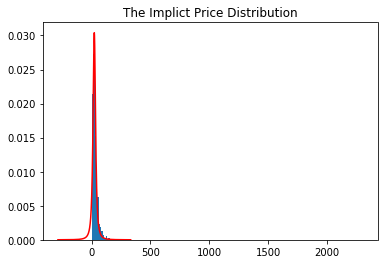

In [9]:
print("This is fitting a t-distribution to the Price data")
print()
dfd, loc, scale = (scipy.stats.t.fit(df['price']))
mean, var, skew, kurt = scipy.stats.t.stats(dfd, loc, scale, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.t.ppf(0.001, dfd, loc, scale),scipy.stats.t.ppf(0.999, dfd, loc, scale), 1000)
py.plot(x, scipy.stats.t.pdf(x, dfd, loc, scale),'r-')
py.hist(df['price'],bins=200,normed=1)
py.title('The Implict Price Distribution')
py.show()

This is fitting a exponential-distribution to the Price data

Moments MVSK are as follows: 33.19055303064944 852.088386243031 2.0 6.0


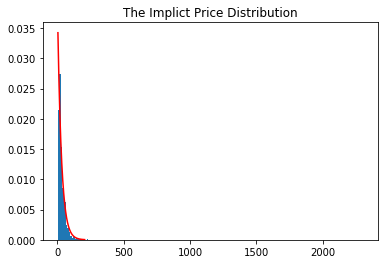

In [10]:
print("This is fitting a exponential-distribution to the Price data")
print()
dfd, loc = (scipy.stats.expon.fit(df['price']))
mean, var, skew, kurt = scipy.stats.expon.stats(dfd, loc,moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)

x = np.linspace(scipy.stats.expon.ppf(0.001, dfd, loc),scipy.stats.expon.ppf(0.999, dfd, loc), 1000)
py.plot(x, scipy.stats.expon.pdf(x, dfd, loc),'r-')
py.hist(df['price'],bins=200,normed=1)
py.title('The Implict Price Distribution')
py.show()

### Looking at the points distribution

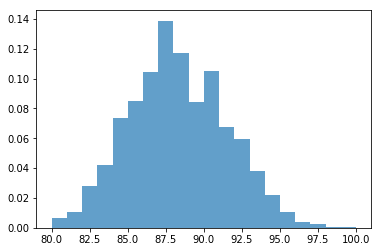

In [11]:
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.show()

This is fitting a normal-distribution to the Points data

Moments MVSK are as follows: 87.80164814951071 10.368441106721427 0.0 0.0



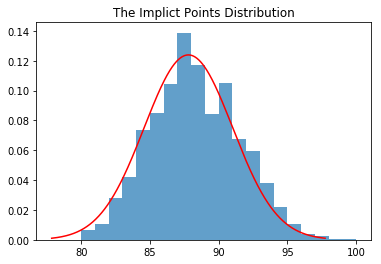

In [12]:
print("This is fitting a normal-distribution to the Points data")
print()
dfd, loc = (scipy.stats.norm.fit(df['points']))
mean, var, skew, kurt = scipy.stats.norm.stats(dfd, loc, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.norm.ppf(0.001, dfd, loc),scipy.stats.norm.ppf(0.999, dfd, loc), 1000)
py.plot(x, scipy.stats.norm.pdf(x, dfd, loc),'r-')
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.title('The Implict Points Distribution')
py.show()

This is fitting a t-distribution to the Points data

Moments MVSK are as follows: 87.80147021535227 10.3684263499024 0.0 9.579444076054575e-07



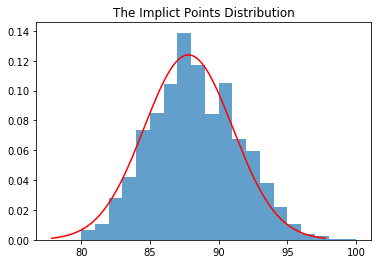

In [13]:
print("This is fitting a t-distribution to the Points data")
print()
dfd, loc, scale = (scipy.stats.t.fit(df['points']))
mean, var, skew, kurt = scipy.stats.t.stats(dfd, loc, scale, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.t.ppf(0.001, dfd, loc, scale),scipy.stats.t.ppf(0.999, dfd, loc,scale), 1000)
py.plot(x, scipy.stats.t.pdf(x, dfd, loc,scale),'r-')
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.title('The Implict Points Distribution')
py.show()

### Exploring the Average Price per Country

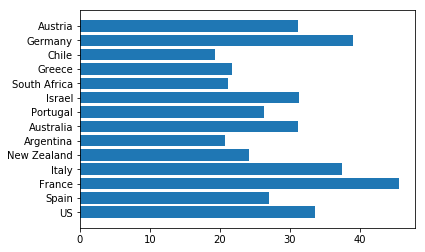

In [14]:
Average_Price_Per_Region=[]
for i in range(0,len(countries_kept)):
    Average_Price_Per_Region.append(np.mean(df.loc[df['country'] == countries_kept[i]]['price']))

y_pos = np.arange(len(Average_Price_Per_Region))
py.barh(y_pos, Average_Price_Per_Region, align='center')
py.yticks(y_pos, countries_kept)
py.show()

### Exploring the Average Points per Country

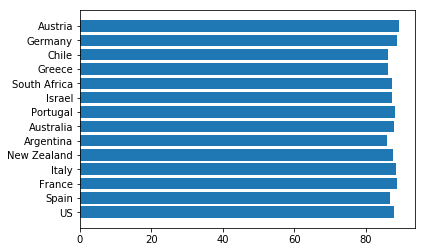

In [15]:
Average_Points_Per_Region=[]
for i in range(0,len(countries_kept)):
    Average_Points_Per_Region.append(np.mean(df.loc[df['country'] == countries_kept[i]]['points']))

y_pos = np.arange(len(Average_Points_Per_Region))
py.barh(y_pos, Average_Points_Per_Region, align='center')
py.yticks(y_pos, countries_kept)
py.show()

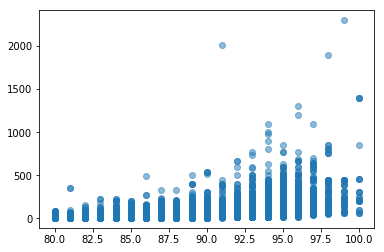

In [16]:
py.scatter(df['points'],df['price'],alpha=0.5)
py.show()
size_of_dataset=[]
size_of_dataset.append(len(df))

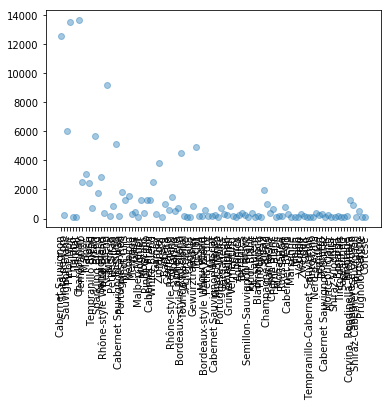

In [17]:
amount_of_varieties = len(df['variety'].unique())
varietal = df['variety'].unique()
varietals = []
amount_of_each_variety = []
fig, ax = py.subplots()
Tol = 74


for i in range(0,amount_of_varieties):
    if len(df.loc[df['variety'] == varietal[i]]) > Tol:
        amount_of_each_variety.append(len(df.loc[df['variety'] == varietal[i]]))
        varietals.append(varietal[i])
py.scatter(np.arange(len(varietals)),amount_of_each_variety,alpha=0.4)
ax.set_xticklabels(varietals)
py.xticks(np.arange(len(varietals)),varietals,rotation='vertical')
py.show()

In [18]:
np.sum(amount_of_each_variety)

129964

In [19]:
np.median(amount_of_each_variety)

310.5

In [20]:
np.size(varietals)

100

In [21]:
df = df[df['variety'].isin(varietals)]
size_of_dataset.append(len(df))

In [22]:
size_of_dataset

[135910, 129964]

In [23]:
varietals

['Cabernet Sauvignon',
 'Tinta de Toro',
 'Sauvignon Blanc',
 'Pinot Noir',
 'Friulano',
 'Tannat',
 'Chardonnay',
 'Tempranillo',
 'Malbec',
 'Rosé',
 'Tempranillo Blend',
 'Syrah',
 'Sparkling Blend',
 'Sangiovese',
 'Rhône-style White Blend',
 'Red Blend',
 'Mencía',
 'Petite Sirah',
 'Riesling',
 'Cabernet Sauvignon-Syrah',
 'Portuguese Red',
 'Pinot Gris',
 'Nebbiolo',
 'Meritage',
 'Glera',
 'Malbec-Merlot',
 'Viognier',
 'Moscato',
 'Pinot Grigio',
 'Cabernet Franc',
 'White Blend',
 'Gamay',
 'Zinfandel',
 'Greco',
 'Barbera',
 'Grenache',
 'Rhône-style Red Blend',
 'Albariño',
 'Carmenère',
 'Bordeaux-style Red Blend',
 'Touriga Nacional',
 'Agiorgitiko',
 'Godello',
 'Gewürztraminer',
 'Merlot',
 'G-S-M',
 'Mourvèdre',
 'Bordeaux-style White Blend',
 'Petit Verdot',
 'Muscat',
 'Cabernet Sauvignon-Merlot',
 'Pinot Bianco',
 'Portuguese White',
 'Garganega',
 'Sauvignon',
 'Grüner Veltliner',
 'Vermentino',
 'Sherry',
 'Aglianico',
 'Torrontés',
 'Primitivo',
 'Semillon-Sauvig

In [24]:
countries_kpt = df['country'].unique()
dummy = pd.get_dummies(df['country'])
country_dummy = []
for i in range(0,len(df['country'].unique())):
    country_dummy.append(dummy[countries_kpt[i]])

In [25]:
countries_kpt

array(['US', 'Spain', 'Italy', 'France', 'New Zealand', 'Argentina',
       'Australia', 'Portugal', 'Israel', 'South Africa', 'Greece',
       'Chile', 'Germany', 'Austria'], dtype=object)

In [26]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[0], y[0]
print(X)
X_points = df[['points']].as_matrix()
X_points= np.c_[X_points,np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[0], y[0]

X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[50], y[50]


[[ 96.   1.   0. ...,   0.   0.   1.]
 [ 96.   0.   1. ...,   0.   0.   1.]
 [ 96.   1.   0. ...,   0.   0.   1.]
 ..., 
 [ 91.   0.   0. ...,   0.   0.   1.]
 [ 90.   0.   0. ...,   0.   0.   1.]
 [ 90.   0.   0. ...,   0.   0.   1.]]


(array([ 90.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]), 18.0)

In [27]:
np.linalg.lstsq(X,y)[0]

array([  5.09496473e+00,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
        -2.36331863e+12])

In [28]:
m,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,c = np.linalg.lstsq(X,y)[0]
print(np.linalg.lstsq(X,y)[0])
w,c1 = np.linalg.lstsq(X_points,y)[0]
print(np.linalg.lstsq(X_points,y)[0])

[  5.09496473e+00   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12  -2.36331863e+12]
[   5.24996669 -427.5377278 ]


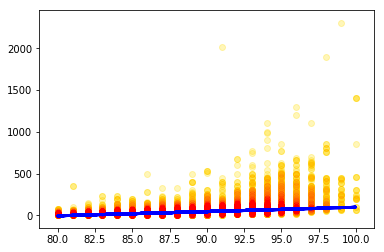

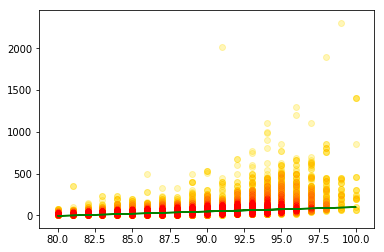

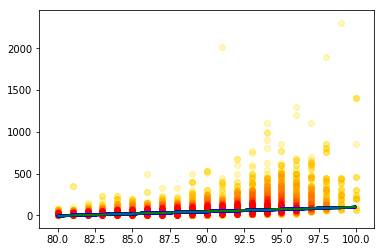

In [29]:
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+c,'b')
py.show()
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],w*df['points']+c1,'g')
py.show()
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+c,'b')
py.plot(df['points'],w*df['points']+c1,'g')
py.show()

In [30]:
error = w*df['points']+c1-(m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+m3+c)
print("How many data points does the simple regression predict a higher price?",len(np.where(error>0)[0]))
np.mean(error)
np.std(error)

How many data points does the simple regression predict a higher price? 0


4.371160453520204

In [31]:
country_dummy

[0         1
 1         0
 2         1
 3         1
 5         0
 6         0
 7         0
 8         1
 9         1
 10        0
 11        1
 12        1
 13        0
 14        1
 15        1
 16        1
 17        0
 18        0
 19        1
 20        1
 21        0
 22        0
 23        1
 24        1
 25        0
 26        1
 27        1
 28        1
 29        1
 31        1
          ..
 150898    0
 150899    0
 150900    0
 150901    0
 150902    0
 150903    0
 150904    0
 150905    0
 150906    0
 150907    0
 150908    0
 150909    0
 150910    0
 150911    0
 150912    0
 150913    0
 150915    1
 150916    1
 150917    0
 150918    0
 150919    0
 150920    0
 150921    0
 150923    0
 150924    0
 150925    0
 150926    0
 150927    0
 150928    0
 150929    0
 Name: US, Length: 129964, dtype: uint8, 0         0
 1         1
 2         0
 3         0
 5         1
 6         1
 7         1
 8         0
 9         0
 10        0
 11        0
 12        0
 13        

In [32]:
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,None,Tinta de Toro,Numanthia
6,Spain,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Toro,None,Tinta de Toro,Maurodos
7,Spain,Lush cedary black-fruit aromas are luxe and of...,Carodorum Único Crianza,95,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm
10,Italy,"Elegance, complexity and structure come togeth...",Ronco della Chiesa,95,80.0,Northeastern Italy,Collio,None,Friulano,Borgo del Tiglio


# Feature engineering for variety

In [33]:
varieties_kpt = df['variety'].unique()
dummy_variety = pd.get_dummies(df['variety'])
country_variety = []
for i in range(0,len(df['variety'].unique())):
    country_variety.append(dummy_variety[varieties_kpt[i]])

In [34]:
country_variety[99]


0         0
1         0
2         0
3         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
31        0
         ..
150898    0
150899    0
150900    0
150901    0
150902    0
150903    0
150904    0
150905    0
150906    0
150907    0
150908    0
150909    0
150910    0
150911    0
150912    0
150913    0
150915    0
150916    0
150917    0
150918    0
150919    0
150920    0
150921    0
150923    0
150924    0
150925    0
150926    0
150927    0
150928    0
150929    0
Name: Cortese, Length: 129964, dtype: uint8

# Decision Trees

In [35]:
from sklearn import tree
import graphviz

In [36]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],country_variety[0],country_variety[1],country_variety[2],country_variety[3],country_variety[4],country_variety[5],country_variety[6],country_variety[7],country_variety[8],country_variety[9],country_variety[10],country_variety[11],country_variety[12],country_variety[13],country_variety[14],country_variety[15],country_variety[16],country_variety[17],country_variety[18],country_variety[19],country_variety[20],country_variety[21],country_variety[22],country_variety[23],country_variety[24],country_variety[25],country_variety[26],country_variety[27],country_variety[28],country_variety[29],country_variety[30],country_variety[31],country_variety[32],country_variety[33],country_variety[34],country_variety[35],country_variety[36],country_variety[37],country_variety[38],country_variety[39],country_variety[40],country_variety[41],country_variety[42],country_variety[43],country_variety[44],country_variety[45],country_variety[46],country_variety[47],country_variety[48],country_variety[49],country_variety[50],country_variety[51],country_variety[52],country_variety[53],country_variety[54],country_variety[55],country_variety[56],country_variety[57],country_variety[58],country_variety[59],country_variety[60],country_variety[61],country_variety[62],country_variety[63],country_variety[64],country_variety[65],country_variety[66],country_variety[67],country_variety[68],country_variety[69],country_variety[70],country_variety[71],country_variety[72],country_variety[73],country_variety[74],country_variety[75],country_variety[76],country_variety[77],country_variety[78],country_variety[79],country_variety[80],country_variety[81],country_variety[82],country_variety[83],country_variety[84],country_variety[85],country_variety[86],country_variety[87],country_variety[88],country_variety[89],country_variety[90],country_variety[91],country_variety[92],country_variety[93],country_variety[94],country_variety[95],country_variety[96],country_variety[97],country_variety[98],country_variety[99],np.ones(len(df['points']))]
Y = df['price'].as_matrix()
clf = tree.DecisionTreeClassifier(max_depth=20)
clf = clf.fit(X, Y)
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

[  3.16859871e+04   1.98463449e+02   1.32098339e+02   1.16569165e+02
   1.15188661e+02   1.03449519e+02   9.88610174e+01   9.06486597e+01
   8.62492118e+01   8.10278821e+01   7.97747512e+01   7.57872886e+01
   7.35137261e+01   7.24034428e+01   7.10728204e+01   6.57719686e+01
   6.29665175e+01   5.67095435e+01   5.29136823e+01   5.14212247e+01
   5.00904178e+01   4.91629802e+01   4.84351024e+01   4.61649767e+01
   4.41667140e+01   4.19952482e+01   3.96293754e+01   3.79999637e+01
   3.73259349e+01   3.63089824e+01   3.57102719e+01   3.56231062e+01
   3.55108957e+01   3.50785294e+01   3.39280178e+01   3.37775745e+01
   3.21341259e+01   3.09207030e+01   3.04108764e+01   2.97029964e+01
   2.84316410e+01   2.75136803e+01   2.66453662e+01   2.59678871e+01
   2.55910425e+01   2.49440881e+01   2.45138851e+01   2.44017517e+01
   2.38031151e+01   2.25885925e+01   2.24006632e+01   2.22290802e+01
   2.15561150e+01   2.09682683e+01   2.02055120e+01   1.95807382e+01
   1.92401727e+01   1.90648851e+01

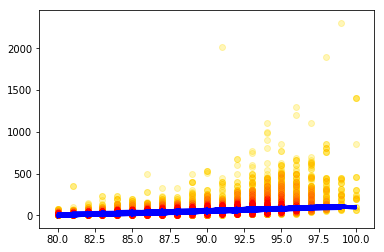

In [ ]:
m,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,c = np.linalg.lstsq(X,y)[0]
print((np.linalg.lstsq(X,y))[3])
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+v0*country_variety[0]+v1*country_variety[1]+v2*country_variety[2]+v3*country_variety[3]+v4*country_variety[4]+v5*country_variety[5]+v6*country_variety[6]+v7*country_variety[7]+v8*country_variety[8]+v9*country_variety[9]+v10*country_variety[10]+v11*country_variety[11]+v12*country_variety[12]+v13*country_variety[13]+v14*country_variety[14]+v15*country_variety[15]+v16*country_variety[16]+v17*country_variety[17]+v18*country_variety[18]+v19*country_variety[19]+v20*country_variety[20]+v21*country_variety[21]+v22*country_variety[22]+v23*country_variety[23]+v24*country_variety[24]+v25*country_variety[25]+v26*country_variety[26]+v27*country_variety[27]+v28*country_variety[28]+v29*country_variety[29]+v30*country_variety[30]+v31*country_variety[31]+v32*country_variety[32]+v33*country_variety[33]+v34*country_variety[34]+v35*country_variety[35]+v36*country_variety[36]+v37*country_variety[37]+v38*country_variety[38]+v39*country_variety[39]+v40*country_variety[40]+v41*country_variety[41]+v42*country_variety[42]+v43*country_variety[43]+v44*country_variety[44]+v45*country_variety[45]+v46*country_variety[46]+v47*country_variety[47]+v48*country_variety[48]+v49*country_variety[49]+v50*country_variety[50]+v51*country_variety[51]+v52*country_variety[52]+v53*country_variety[53]+v54*country_variety[54]+v55*country_variety[55]+v56*country_variety[56]+v57*country_variety[57]+v58*country_variety[58]+v59*country_variety[59]+v60*country_variety[60]+v61*country_variety[61]+v62*country_variety[62]+v63*country_variety[63]+v64*country_variety[64]+v65*country_variety[65]+v66*country_variety[66]+v67*country_variety[67]+v68*country_variety[68]+v69*country_variety[69]+v70*country_variety[70]+v71*country_variety[71]+v72*country_variety[72]+v73*country_variety[73]+v74*country_variety[74]+v75*country_variety[75]+v76*country_variety[76]+v77*country_variety[77]+v78*country_variety[78]+v79*country_variety[79]+v80*country_variety[80]+v81*country_variety[81]+v82*country_variety[82]+v83*country_variety[83]+v84*country_variety[84]+v85*country_variety[85]+v86*country_variety[86]+v87*country_variety[87]+v88*country_variety[88]+v89*country_variety[89]++v90*country_variety[90]+v91*country_variety[91]+v92*country_variety[92]+v93*country_variety[93]+v94*country_variety[94]+v95*country_variety[95]+v96*country_variety[96]+v97*country_variety[97]+v98*country_variety[98]+v99*country_variety[99]+c,'b')
py.show()

In [ ]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],country_variety[0],country_variety[1],country_variety[2],country_variety[3],country_variety[4],country_variety[5],country_variety[6],country_variety[7],country_variety[8],country_variety[9],country_variety[10],country_variety[11],country_variety[12],country_variety[13],country_variety[14],country_variety[15],country_variety[16],country_variety[17],country_variety[18],country_variety[19],country_variety[20],country_variety[21],country_variety[22],country_variety[23],country_variety[24],country_variety[25],country_variety[26],country_variety[27],country_variety[28],country_variety[29],country_variety[30],country_variety[31],country_variety[32],country_variety[33],country_variety[34],country_variety[35],country_variety[36],country_variety[37],country_variety[38],country_variety[39],country_variety[40],country_variety[41],country_variety[42],country_variety[43],country_variety[44],country_variety[45],country_variety[46],country_variety[47],country_variety[48],country_variety[49],country_variety[50],country_variety[51],country_variety[52],country_variety[53],country_variety[54],country_variety[55],country_variety[56],country_variety[57],country_variety[58],country_variety[59],country_variety[60],country_variety[61],country_variety[62],country_variety[63],country_variety[64],country_variety[65],country_variety[66],country_variety[67],country_variety[68],country_variety[69],country_variety[70],country_variety[71],country_variety[72],country_variety[73],country_variety[74],country_variety[75],country_variety[76],country_variety[77],country_variety[78],country_variety[79],country_variety[80],country_variety[81],country_variety[82],country_variety[83],country_variety[84],country_variety[85],country_variety[86],country_variety[87],country_variety[88],country_variety[89],country_variety[90],country_variety[91],country_variety[92],country_variety[93],country_variety[94],country_variety[95],country_variety[96],country_variety[97],country_variety[98],country_variety[99],np.ones(len(df['points']))]
Y = df['price'].as_matrix()
clf = tree.DecisionTreeRegressor(criterion="mae",max_leaf_nodes = 100)
# useful code: min_samples_leaf=10,max_depth=3,max_leaf_nodes = 100
clf = clf.fit(X, Y)
clf

In [ ]:
npy = []
npy.append('points')
for i in countries_kpt:
    npy.append(i)
for i in varieties_kpt:
    npy.append(i)
npy.append('ones')

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=npy,  
                        class_names=['price'],  
                        filled=True, rounded=True,  
                        special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("data", view=True) 
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                         feature_names=npy,  
#                         class_names=['price'],  
#                         filled=True, rounded=True,  
#                         special_characters=True)  
#graph = graphviz.Source(dot_data)  
#graph



In [ ]:
# How to buy cheap wine 101

for i in df.index:
    if df['price'][i] <= 7:
        if df['points'][i] >= 90:
            print("Points",df['points'][i], "winery", df['winery'][i], "variety", df['variety'][i], "price", df['price'][i])